<a href="https://colab.research.google.com/github/pachterlab/GYP_2022/blob/dev/gg220909_telegraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating switching processes coupled to non-Markovian processing

This notebook uses a modified version of the Gillespie algorithm to simulate a telegraph model of gene switching coupled to a mixed Markovian/non-Markovian model of mRNA splicing and degradation. We implement these simulations to validate generating function-based solutions to these systems.

Import relevant packages.

# Helper functions

In [1]:
import numpy as np
from numpy import matlib
import scipy.stats

import numba
import tqdm
import multiprocessing
import scipy
from scipy.fft import ifft, ifft2, ifftn, irfft, irfftn


import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import time
t1 = time.time()

## Simulation

In [2]:
@numba.njit
def update_rule(population, *args):
    '''
    Update rule that takes params and 
    updates the population matrix
    '''
    k_on, k_off, k, b1 = args
    m0, m1, m2 = population    
    flux =np.zeros(4)
    flux[0], flux[1], flux[2], flux[3] = k_on*(1-m0), k_off*m0, k*m0, b1*m1
    return flux
    
def sample_rxns(prob_arr):
    '''
    Takes prob_arr and
    returns an randomly sampled index according to 
    the probabilities specificed in prob_arr
    '''
    num = np.random.rand()
    sent = 0
    tot = 0.
    while tot < num:
        tot = tot + prob_arr[sent]
        sent = sent + 1
    return sent - 1

def step(calc_flux, population, t, *args):
    '''
    Takes flux calculating function, past event, 
    flux, population, t, args and
    returns time to reaction and the reaction that happens
    '''
    # print(args)
    flux = calc_flux( population, *args)[0]
    # print(flux)
    flux_sum = np.sum(flux)
    t = np.random.exponential(1. / flux_sum)
    rxn_prob = flux/flux_sum
    rxn = sample_rxns(rxn_prob)
    
    return rxn, t
def step_with_queued(calc_flux,population,t,queued_reactions,queued_reaction_times,export_arr,*args):
    '''
    Takes flux calculating function, past event, 
    flux, population, t, args and
    returns time to reaction and the reaction that happens
    '''
    # return step(calc_flux,population,t,*args)
    if len(queued_reactions)==0:
        return step(calc_flux,population,t,*args)
    else:
        # 
        population = np.copy(population)
        population_orig = np.copy(population)
        # queued_reactions = np.copy(queued_reactions)
        queued_reaction_times = np.copy(queued_reaction_times)

        init_flux = calc_flux( population, *args)[0]
        n_rxn = len(init_flux)
        fluxes = np.zeros((len(queued_reactions)+1,n_rxn))
        fluxes[0] = calc_flux( population, *args)[0]
        for q in range(len(queued_reactions)):
            population += export_arr[queued_reactions[q]]
            fluxes[q+1] = calc_flux( population, *args)[0]

        queued_reaction_times = np.concatenate(([t],queued_reaction_times))
        flux_sums = fluxes[:-1] * np.diff(queued_reaction_times)[:,None]
        flux_sums = np.concatenate((np.zeros(n_rxn)[None,:],flux_sums))
        flux_cumsums = np.cumsum(flux_sums,0)
        tot_flux_cumsum = flux_cumsums.sum(1)

        u = np.random.rand()
        flux = np.log(1/u)
        
        last_ind = np.where(tot_flux_cumsum<flux)[0][-1]
        dt = queued_reaction_times[last_ind]-t
        flux_orig = np.copy(flux)
        flux -= tot_flux_cumsum[last_ind]
        dtprime = flux/fluxes[last_ind].sum()
        dt += dtprime

        flux_sum = fluxes[last_ind]
        rxn_prob = flux_sum / flux_sum.sum()
        rxn = sample_rxns(rxn_prob)   
        return rxn, dt

def markovian_simulate(calc_flux, update, population_0, t_arr, tau, \
                       DELAYED_SPECIES_GENERATORS, export_arr,tau_list=None,\
                       return_full=False,*args):
    '''
    Takes params and
    returns matrix of the number of counts for 
    a species j at time t[i]
    '''
    if isinstance(tau , list) or isinstance(tau , tuple) :
        n_delays = len(tau)
    else:
        tau = [tau]
        n_delays = 1

    population_arr = np.zeros((len(t_arr), update.shape[1]))
    t = t_arr[0]
    population = population_0.copy()
    population_arr[0, :] = population
    t_list = []
    population_list = []
    rxn_list = []

    t_list.append(t)
    population_list.append(population)

    # Delay time queue
    if tau_list is None:
        tau_list = [[]]*n_delays
    tau_list_delay_inds = np.asarray(sum([[j]*len(x) for j,x in enumerate(tau_list)],[]))
    tau_list_all_delays = np.concatenate(tau_list)
    tau_list_sort = np.argsort(tau_list_all_delays).astype(int)

    tau_list_delay_inds = list(tau_list_delay_inds[tau_list_sort])
    tau_list_all_delays = list(tau_list_all_delays[tau_list_sort])
    
    while t < t_arr[-1]:
        event,dt = step_with_queued(calc_flux,population,t,\
                                    tau_list_delay_inds,tau_list_all_delays,\
                                    export_arr, *args)
        

        temp_t = t + dt
        
        # Check if an export event should slot in before t + dt
        while (len(tau_list_all_delays) != 0) and (temp_t > tau_list_all_delays[0]):
            population = population + export_arr[tau_list_delay_inds[0]]
            t = tau_list_all_delays[0]
            if t>t_arr[-1]:
                break
            t_list.append(t)
            population_list.append(population)
            rxn_list.append(-tau_list_delay_inds[0]-1)
            tau_list_all_delays.pop(0) # remove element
            tau_list_delay_inds.pop(0)

        if len(tau_list_all_delays)!=len(tau_list_delay_inds):
            raise ValueError
        
        # Perform event
        population = population + update[event, :]
        t = temp_t
        t_list.append(t)
        population_list.append(population)
        rxn_list.append(event)


        for j in range(n_delays):
            if event in DELAYED_SPECIES_GENERATORS[j]:
                tau_list_all_delays.append(t + tau[j])
                tau_list_delay_inds.append(j)
        tau_list_sort = np.argsort(tau_list_all_delays).astype(int)
        tau_list_delay_inds = list(np.asarray(tau_list_delay_inds)[tau_list_sort])
        tau_list_all_delays = list(np.asarray(tau_list_all_delays)[tau_list_sort])
    
    t_only_arr = np.asarray(t_list)
    population_list= np.asarray(population_list)
    for i in range(len(t_only_arr)):
        # print(t_only_arr)
        ind = np.searchsorted(t_arr, t_only_arr[i], side = 'right')
        # print(ind)
        population_arr[ind:] = np.array(population_list[i])
    if return_full:
        return population_arr,t_only_arr,population_list,rxn_list
    else:
        return population_arr

## Simulation setup 


In [3]:
def nondelay_wrapper(N,n,K_val,A_val,beta_val,gamma_val,initcond,number_of_cells=5000,simulation_time=5,ndel=50):

    H,A,C,S,k,Hss = sim_setup(N,n,K_val,A_val,beta_val,gamma_val)

    delayed_species = []
    DELAYED_SPECIES_GENERATORS = [[]]

    tau = []

    ####
    update_arr = S

    t_arr = np.linspace(0, simulation_time, ndel,endpoint=False)


    export_arr = np.zeros((len(delayed_species),N+n),dtype=int)


    samples = np.zeros((number_of_cells, len(t_arr), N+n))


    Hss = scipy.linalg.null_space(H.T)
    Hss /= Hss.sum()
    Hss = Hss.squeeze()

    for i in tqdm.tqdm(range(number_of_cells)):
        population_0 = np.zeros(N+n,dtype=int)
        if initcond[0][0]=='thermalized':
            init_state_prob = Hss
        elif isinstance(initcond[0][1],int):
            init_state_prob = np.zeros(N)
            jinit = initcond[0][1]
            init_state_prob[jinit] = 1
        else:
            init_state_prob = initcond[0][1]
        if N>1:
            population_0[:N] = np.random.multinomial(1,init_state_prob,1)
        else:
            population_0[:N] = 1
        initial_promoter_state = np.where(population_0[:N]==1)[0][0]

        for j,condition in enumerate(initcond[1:]):
            if isinstance(condition[0],str):
                if condition[0]=='deterministic':
                    population_0[j+N] = condition[1]
                elif condition[0]=='poisson':
                    population_0[j+N] = np.random.poisson(condition[1])
            else:
                if condition[initial_promoter_state][0]=='deterministic':
                    population_0[j+N] = condition[initial_promoter_state][1]
                elif condition[initial_promoter_state][0]=='poisson':
                    population_0[j+N] = np.random.poisson(condition[initial_promoter_state][1])
# # print('initcond')
            # if condition[0]=='deterministic':
            #     population_0[j+N] = condition[1]
            # elif condition[0]=='poisson':
            #     population_0[j+N] = np.random.poisson(condition[1])
        samples[i, :, :],event_t,event_x,_ = markovian_simulate(
            propfun_generic, update_arr, population_0, t_arr, \
            tau, DELAYED_SPECIES_GENERATORS, export_arr,[[]],\
            True,(k,K_val,A_val,beta_val,gamma_val,N))
    return t_arr,samples,H,A,C,init_state_prob

In [4]:
def sim_setup(N,n,K_val,A_val,beta_val,gamma_val):

    H = np.zeros((N,N))
    for kv in K_val:
        H[kv[0],kv[1]] = kv[2]
    H -= np.diag(H.sum(1))

    A = np.zeros((N,n))
    for av in A_val:
        A[av[0],av[1]-1] = av[2]

    B = np.zeros((n,n))
    for bv in beta_val:
        B[bv[0]-1,bv[1]-1] = bv[2]
    B -= np.diag(B.sum(1))
    for gv in gamma_val:
        B[gv[0]-1,gv[0]-1] -= gv[1]
    

    Nspec = N+n
    Nrxn = len(K_val) + len(A_val) + len(gamma_val) + len(beta_val)
    S_mark = np.zeros((Nrxn,Nspec))
    k_mark = np.zeros(Nrxn)

    i=0
    for kv in K_val:
        S_mark[i,kv[0]] = -1
        S_mark[i,kv[1]] = 1
        k_mark[i] = kv[2]
        i+=1

    for av in A_val:
        S_mark[i,av[1]+N-1] = 1
        k_mark[i] = av[2]
        i+=1
        
    for bv in beta_val:
        S_mark[i,bv[0]+N-1] = -1
        S_mark[i,bv[1]+N-1] = 1
        k_mark[i] = bv[2]
        i+=1
        
    for gv in gamma_val:
        S_mark[i,gv[0]+N-1] = -1    
        k_mark[i] = gv[1]
        i+=1

    Hss = scipy.linalg.null_space(H.T)
    Hss /= Hss.sum()
    Hss = Hss.squeeze()

    S_mark = S_mark.astype(int)

    return H,A,B,S_mark,k_mark,Hss
    # print(B)

def propfun_generic(x,*args):
    # print(args)
    k,K_val,A_val,beta_val,gamma_val,N = args[0]
    nRxn = len(k)
    nCells = x.shape[0]

    a = np.zeros((nCells,nRxn),dtype=float)
    x = x.T
    a = a.T
    #######
    j = 0 
    for i in range(len(K_val)):
        a[j] = k[j] * x[K_val[i][0]]
        j+=1
    for i in range(len(A_val)):
        a[j] = k[j] * x[A_val[i][0]]
        j+=1
    for i in range(len(beta_val)):
        a[j] = k[j] * x[beta_val[i][0]+N-1]
        j+=1
    for i in range(len(gamma_val)):
        a[j] = k[j] * x[gamma_val[i][0]+N-1]
        j+=1
    # print(a)
    # print(x)
    # raise ValueError
    return a.T

## Analytical solution for the 5-species system

In [5]:
def pss_wrapper_special(H,A,k,tau,t,mx,N,initcond):
    c23,c24,c30=k
    t1,t4=tau
    r2=c23+c24
    g = np.asarray(get_g(mx)).T
    ufun_specific = lambda s,g:  np.asarray([\
                    U1(s,g,c23,c24,r2,c30,t4,t1),\
                    U2(s,g,c23,c24,r2,c30,t4),\
                    U3(s,g,c30),\
                    U4(s,g,t4)])

    if initcond[0][0]=='thermalized':
        Hfin = scipy.linalg.null_space(H.T)
        Hfin /= Hfin.sum()
        w = Hfin.squeeze()
    elif initcond[0][0]=='deterministic':
        w = np.zeros(N)
        w[initcond[0][1]] = 1
    elif initcond[0][0]=='categorical':
        w = initcond[0][1]
    else:
        raise ValueError('Not implemented')
    w = np.asarray(w,dtype=np.complex128)

    gf_initcond_prop = np.ones((g.shape[0],N),dtype=np.complex128)

    for j,condition in enumerate(initcond[1:]):
        if isinstance(condition[0],str): #Identical conditions for all states
            if condition[0]=='deterministic':
                initcond_gfun = lambda x: (x+1)**condition[1]
            elif condition[0]=='poisson':
                initcond_gfun = lambda x: np.exp(condition[1]*x)
            for i in range(g.shape[0]):
                gf_initcond_prop[i,:] *= initcond_gfun(ufun_specific(t,g[i])[j])
        elif len(condition)==N: #list of length N
            for k in range(N):
                if condition[k][0]=='deterministic':
                    initcond_gfun = lambda x: (x+1)**condition[k][1]
                elif condition[k][0]=='poisson':
                    initcond_gfun = lambda x: np.exp(condition[k][1]*x)
                for i in range(g.shape[0]):
                    gf_initcond_prop[i,k] *= initcond_gfun(ufun_specific(t,g[i])[j])
        else: 
            print(N)
            print(len(condition[0]))
            raise ValueError
    gf_initcond_prop *= w 
    gf = gfun_specific(g,t,H,A,N,ufun_specific,gf_initcond_prop)

    Pss = np.zeros((max(mx),N))
    for j in range(N):
        Pss[:,j] = np.real(ifft(gf[:,j]))
    return Pss.squeeze()

def gfun_specific(g,t,H,A,N,ufun_specific,gf_initcond):
    gf_ = np.zeros((g.shape[0],N),dtype=np.complex128)
    
    for i in (range(g.shape[0])):
        t0 = 0
        y0 = gf_initcond[i]
        
        Ufun = lambda x:  ufun_specific(x,g[i])
        intfun = lambda t,y: intfun_multi(t,y,H,A,Ufun)
        res = scipy.integrate.solve_ivp(intfun,[t,t0],y0)
        while res.status == 'running':
            res.step()
        gf_[i] = res.y[:,-1]
    return gf_


###################

def U1(s,g,c23,c24,r2,c30,t4,t1):
    return g[0]*U1_1(s,t1) + g[1]*U1_2(s,t1,r2) + g[2]*U1_3(s,t1,r2,c23,c30) + g[3]*U1_4(s,t1,t4,r2,c24)

def U1_1(s,t1): return (1 if (s<=t1) else 0)
def U1_2(s,t1,r2): return (np.exp(-r2*(s-t1)) if s>t1 else 0)
def U1_3(s,t1,r2,c23,c30): 
    return (c23/(r2-c30)*(np.exp(-c30*(s-t1))-np.exp(-r2*(s-t1))) if s>t1 else 0)
def U1_4(s,t1,t4,r2,c24):
    integrand = 0
    if s>t1:
        integrand -= np.exp(-r2*(s-t1))
        if s>t1+t4:
            integrand += np.exp(-r2*(s-t1-t4))
        else:
            integrand += 1
    integrand *= c24/r2
    return integrand

###################

def U2(s,g,c23,c24,r2,c30,t4):
    return g[0]*U2_1(s) + g[1]*U2_2(s,r2) + g[2]*U2_3(s,c23,r2,c30) + g[3]*U2_4(s,c24,r2,t4)

def U2_1(s): return 0
def U2_2(s,r2):
    return np.exp(-r2*s)
def U2_3(s,c23,r2,c30):
    return c23/(r2-c30)*(np.exp(-c30*s)-np.exp(-r2*s))
def U2_4(s,c24,r2,t4):
    integrand = -np.exp(-r2*s)
    if s>t4:
        integrand += np.exp(-r2*(s-t4))
    else:
        integrand += 1
    integrand *= c24/r2
    return integrand

###################

def U3(s,g,c30):
    return g[0]*U3_1(s) + g[1]*U3_2(s) + g[2]*U3_3(s,c30) + g[3]*U3_4(s)

def U3_1(s): return 0
def U3_2(s): return 0
def U3_3(s,c30):
    return np.exp(-c30*s)
def U3_4(s): return 0

###################

def U4(s,g,t4):
    return g[0]*U4_1(s) + g[1]*U4_2(s) + g[2]*U4_3(s) + g[3]*U4_4(s,t4)

def U4_1(s): return 0
def U4_2(s): return 0
def U4_3(s): return 0
def U4_4(s,t4): return (1 if (s<=t4) else 0)


## PGF computation for generic non-delayed systems

In [6]:
def get_g(mx):
    u = []
    for i in range(len(mx)):
        l = np.arange(mx[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    return g

def compute_coeff(L,V,Vinv,u,j=0):
    n_u = u.shape[1]
    a = np.asarray([(V@np.diag( Vinv @ u[:,i]))[j] for i in range(n_u)]).T
    return a

def compute_eigs(C):
    L,V = np.linalg.eig(C)
    Vinv = np.linalg.inv(V)
    return L,V,Vinv


In [8]:
def pss_wrapper(H,A,C,t,mx,n,N,initcond):
    g = np.asarray(get_g(mx)).T
    L,V,Vinv = compute_eigs(C)
    coeff = np.asarray([compute_coeff(L,V,Vinv,g.T,i) for i in range(n)])
    
    if initcond[0][0]=='thermalized':
        Hfin = scipy.linalg.null_space(H.T)
        Hfin /= Hfin.sum()
        w = Hfin.squeeze()
    elif initcond[0][0]=='deterministic':
        w = np.zeros(N)
        w[initcond[0][1]] = 1
    elif initcond[0][0]=='categorical':
        w = initcond[0][1]
    else:
        raise ValueError('Not implemented')
    w = np.asarray(w,dtype=np.complex128)

    gf_initcond_prop = np.ones((g.shape[0],N),dtype=np.complex128)

    for j,condition in enumerate(initcond[1:]):
        if isinstance(condition[0],str): #Identical conditions for all states
            if condition[0]=='deterministic':
                initcond_gfun = lambda x: (x+1)**condition[1]
            elif condition[0]=='poisson':
                initcond_gfun = lambda x: np.exp(condition[1]*x)
            for i in range(g.shape[0]):
                gf_initcond_prop[i,:] *= initcond_gfun(ufun_generic(t,L,coeff[j,:,i]))
        elif len(condition)==N: #list of length N
            for k in range(N):
                if condition[k][0]=='deterministic':
                    initcond_gfun = lambda x: (x+1)**condition[k][1]
                elif condition[k][0]=='poisson':
                    initcond_gfun = lambda x: np.exp(condition[k][1]*x)
                for i in range(g.shape[0]):
                    gf_initcond_prop[i,k] *= initcond_gfun(ufun_generic(t,L,coeff[j,:,i]))
        else: 
            print(N)
            print(len(condition[0]))
            raise ValueError
    gf_initcond_prop *= w 
    gf = gfun_numerical(g,t,H,A,N,L,coeff,gf_initcond_prop)

    Pss = np.zeros((max(mx),N))
    for j in range(N):
        Pss[:,j] = np.real(ifft(gf[:,j]))
    return Pss.squeeze()

def gfun_numerical(g,t,H,A,N,L,coeff,gf_initcond):
    gf_ = np.zeros((g.shape[0],N),dtype=np.complex128)
    
    for i in (range(g.shape[0])):
        t0 = 0
        y0 = gf_initcond[i]
        
        Ufun = lambda x: np.asarray([ufun_generic(x,L,coef[:,i]) for coef in coeff])
        intfun = lambda t,y: intfun_multi(t,y,H,A,Ufun)
        res = scipy.integrate.solve_ivp(intfun,[t,t0],y0)
        while res.status == 'running':
            res.step()
        gf_[i] = res.y[:,-1]
    return gf_

def ufun_generic(x,L,coeff):
    Ufun = (np.exp(L*x)@coeff)
    return Ufun

def intfun_multi(t,y,H,A,Ufun):
    dy = np.dot(H.T,y) + np.dot(A,Ufun(t))*y
    return -dy

## Visualization for generic non-delayed systems

In [9]:
conditional_colors = ('red','cadetblue','deeppink','khaki')
uncond_colors = ('lightgray','darkgray')
alf=0.5

In [10]:
def viz_nondelay(t_arr,samples,N,n,H,A,C,initcond,init_state_prob):
    nt=5
    fig1,ax1=plt.subplots(nt,n+1,figsize=(12,12))
    for k,tind in enumerate([0,2,5,10,49]):
        t=t_arr[tind]

        X=samples[:,tind,:]
        ax1[k,0].bar(np.arange(N),X[:,:N].mean(0),color='lightgray')

        Pss_gene = np.dot(scipy.linalg.expm(t*H.T),init_state_prob)
        ax1[k,0].plot(Pss_gene,'r-')

        ax1[k,0].set_xticks([])
        ax1[k,0].set_yticks([])
        ax1[k,0].set_ylabel('t = {:.2f}'.format(t))
        for i in range(n):
            mx = [1]*n

            ub = X[:,N+i].max() + 6
            mx[i] = int(ub)
            Pss = pss_wrapper(H,A,C,t,mx,n,N,initcond)
            for j in range(N):
                cf = X[:,j]==1
                
                bins = np.arange(ub)-0.5
                hist,_ = np.histogram(X[cf,N+i],bins,density=True)
                ax1[k,i+1].bar(bins[:-1]+0.5,hist*Pss_gene[j],color=conditional_colors[j],alpha=alf)
                ax1[k,i+1].plot(Pss[:,j],color=conditional_colors[j],alpha=alf)

            bins = np.arange(X[:,N+i].max()+6)-0.5
            hist,_ = np.histogram(X[:,N+i],bins,density=True)
            ax1[k,i+1].bar(bins[:-1]+0.5,hist,color=uncond_colors[0],alpha=alf)

            ax1[k,i+1].plot(Pss.sum(1),color=uncond_colors[1])


            ax1[k,i+1].set_xticks([])
            ax1[k,i+1].set_yticks([])
    fig1.tight_layout()
    # return Pss

# Scenarios

Here, we consider systems in order of increasing complexity, and compare their solutions to simulations. "Homogeneous" means the system starts at zero molecules. "Thermalized" means its initial distribution over gene states is the steady state.

In [11]:
k_on = .75
k_off = .5

N = 2
K_val = [[0,1,k_off],
         [1,0,k_on]]

n = 2
A_val =[[0,1,10]]
    
gamma_val = [[2,3.14]]
beta_val = [[1,2,1.2]]

## 2-state, 2-species, homogeneous thermalized

In [12]:
initcond = [['thermalized'],
            ['deterministic',0],
            ['deterministic',0]]
t_arr,samples,H,A,C,init_state_prob = nondelay_wrapper(N,n,K_val,A_val,beta_val,gamma_val,initcond)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 332.45it/s]


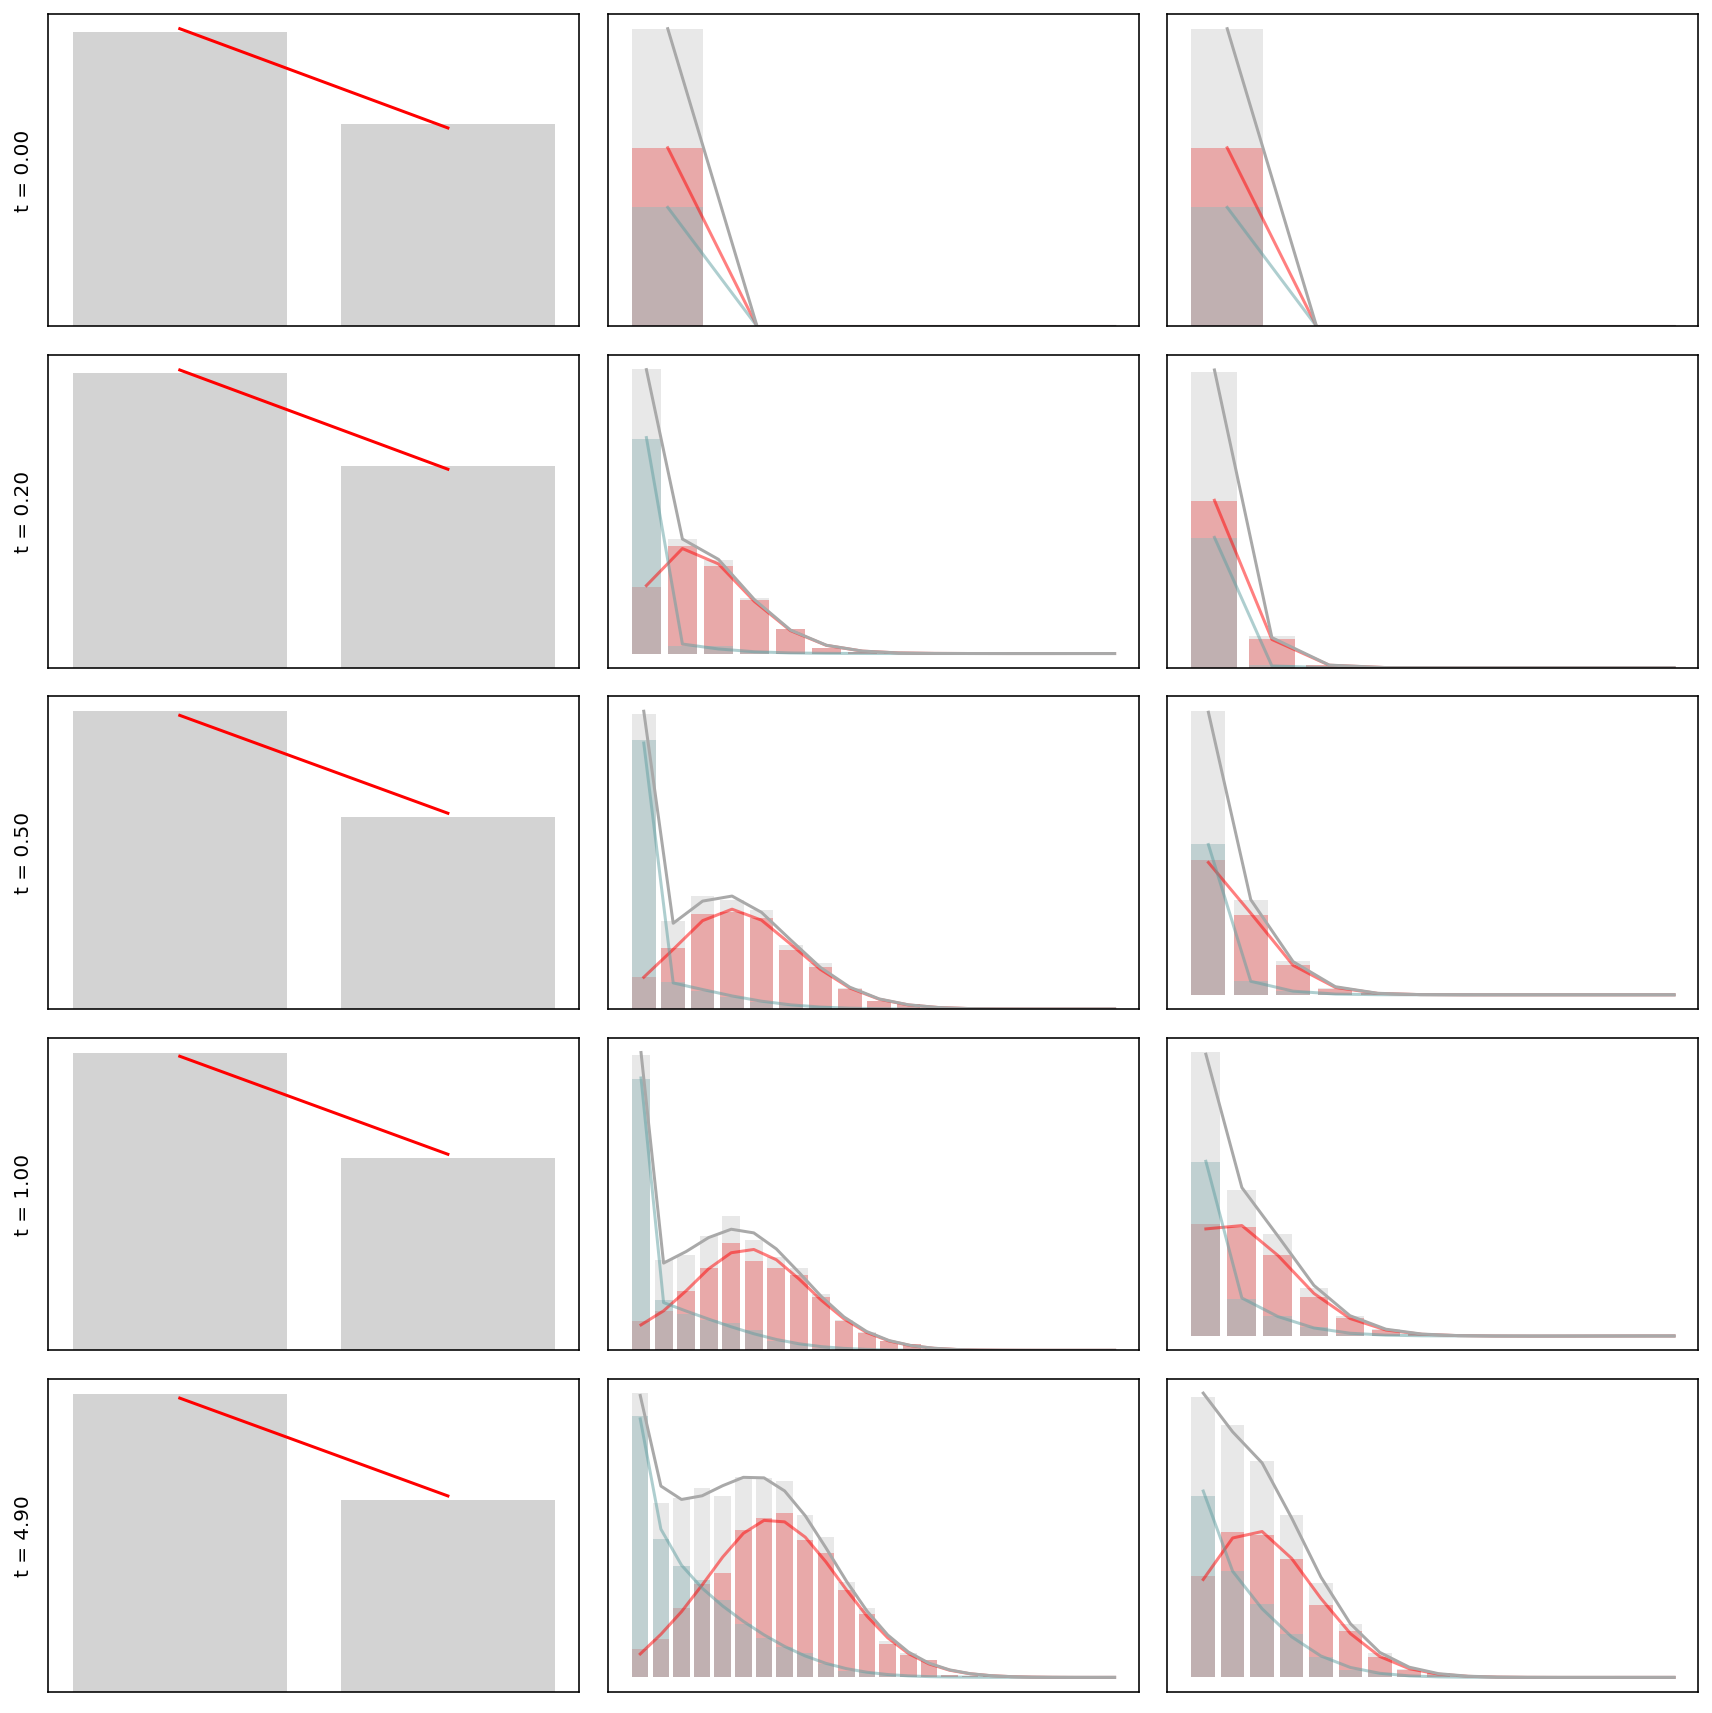

In [13]:
viz_nondelay(t_arr,samples,N,n,H,A,C,initcond,init_state_prob)

## 2-state, 2-species, homogeneous started at single state

In [14]:
initcond = [['deterministic',0],
            ['deterministic',0],
            ['deterministic',0]]
t_arr,samples,H,A,C,init_state_prob = nondelay_wrapper(N,n,K_val,A_val,beta_val,gamma_val,initcond)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 304.75it/s]


/home/ggorin/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


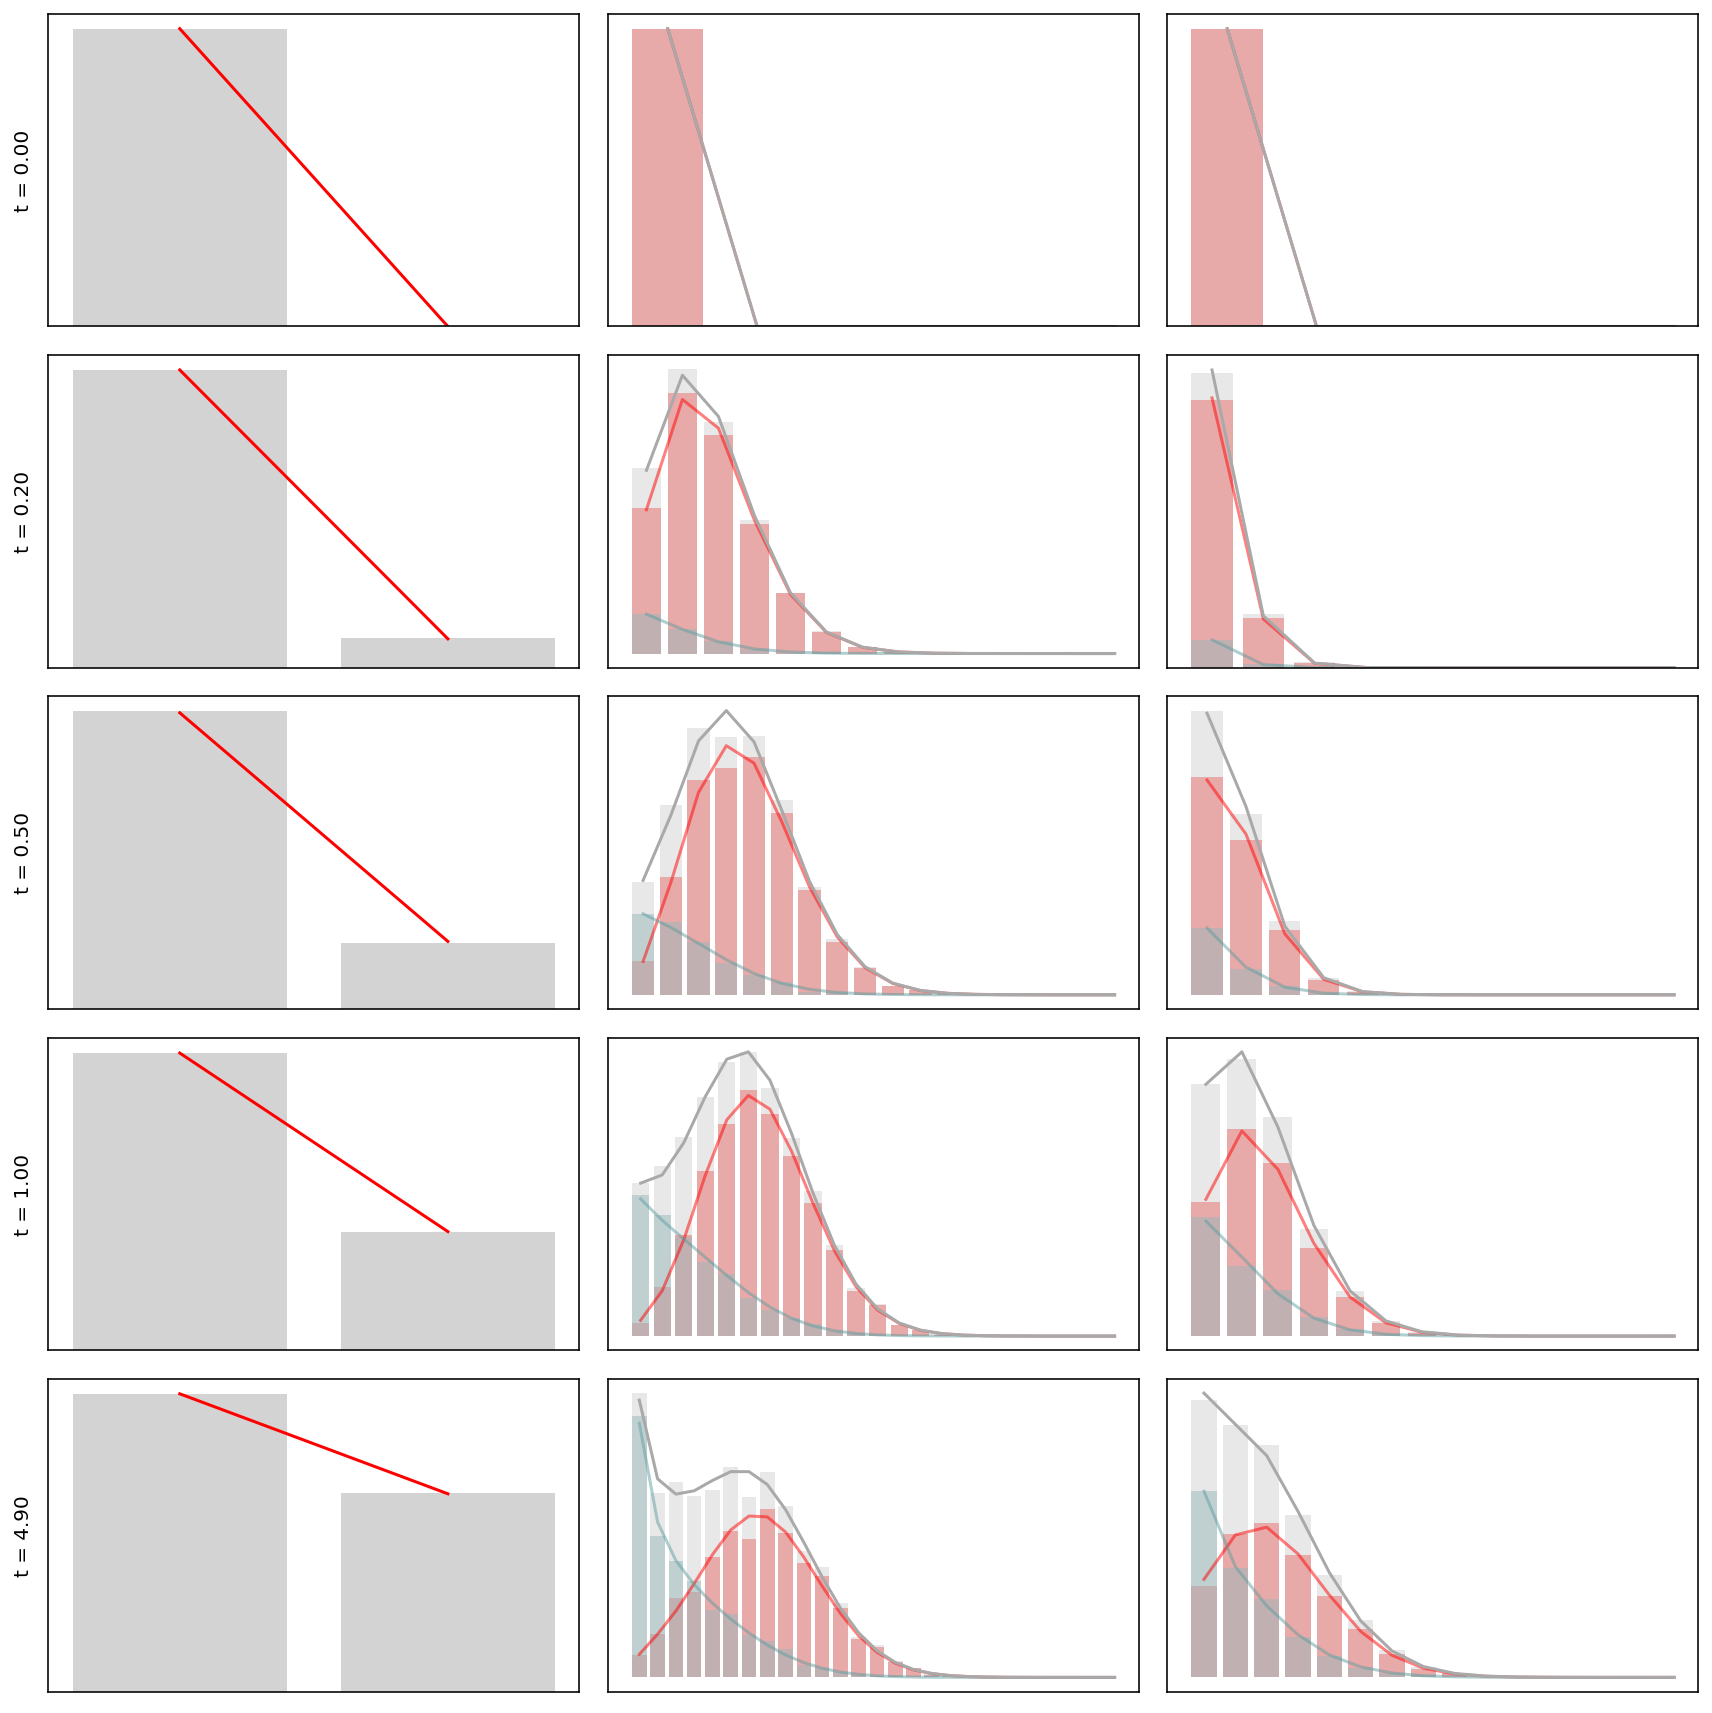

In [15]:
viz_nondelay(t_arr,samples,N,n,H,A,C,initcond,init_state_prob)

In [16]:
initcond = [['deterministic',1],
            ['deterministic',0],
            ['deterministic',0]]
t_arr,samples,H,A,C,init_state_prob = nondelay_wrapper(N,n,K_val,A_val,beta_val,gamma_val,initcond)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 440.94it/s]


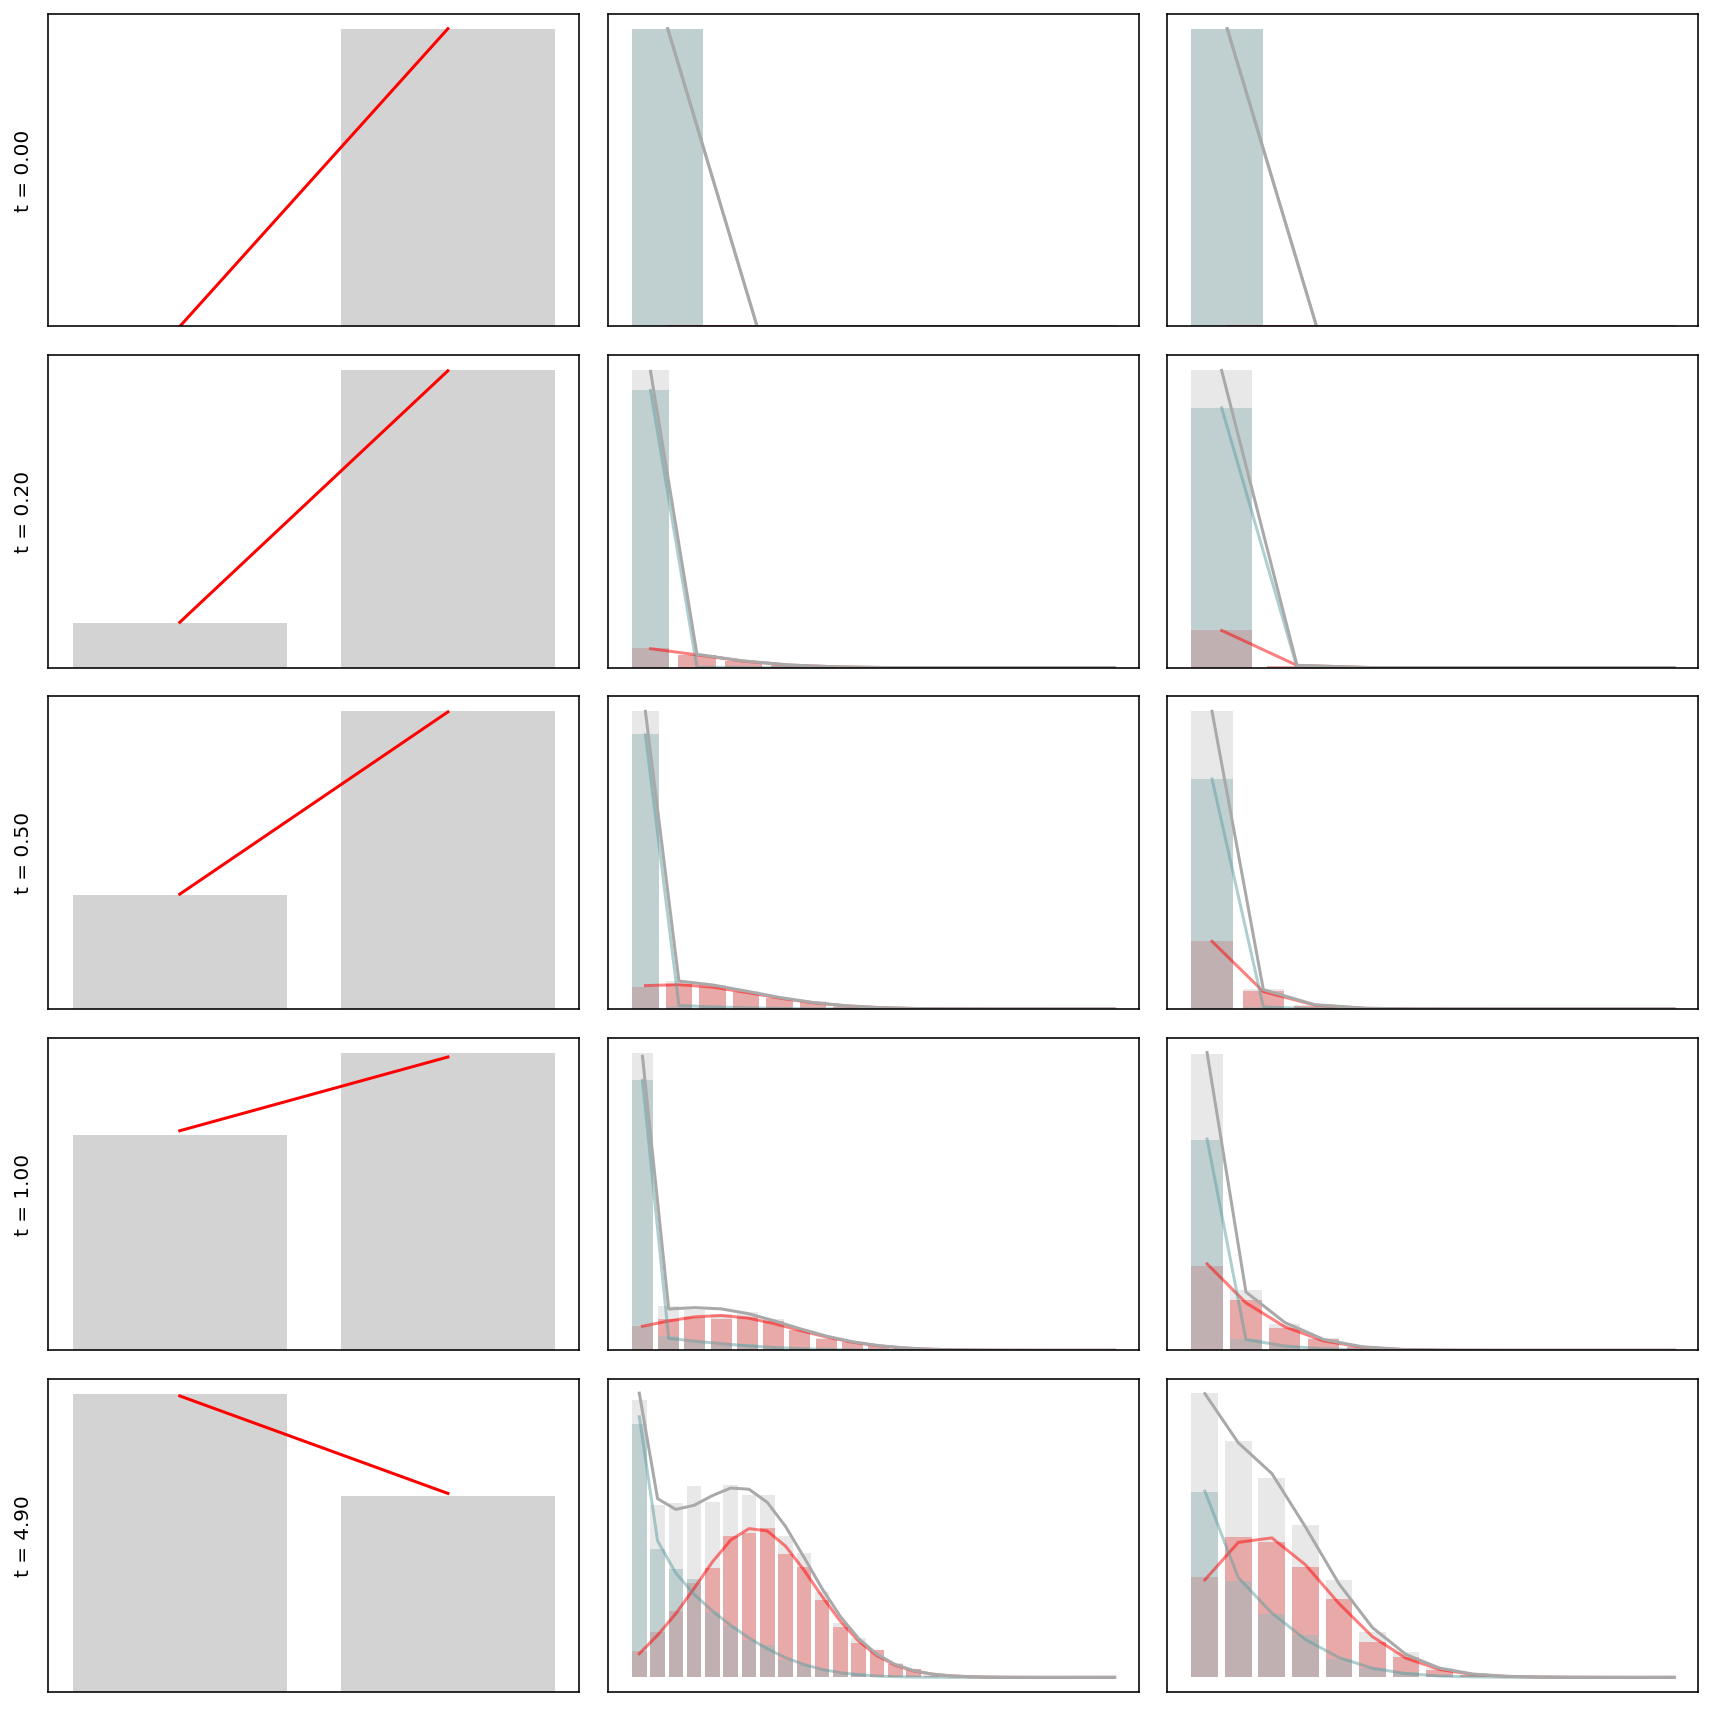

In [17]:
viz_nondelay(t_arr,samples,N,n,H,A,C,initcond,init_state_prob)

## 2-state, 2-species, homogeneous started at arbitrary state distribution

In [18]:
initcond = [['categorical',[0.3,0.7]],
            ['deterministic',0],
            ['deterministic',0]]
t_arr,samples,H,A,C,init_state_prob = nondelay_wrapper(N,n,K_val,A_val,beta_val,gamma_val,initcond)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 394.03it/s]


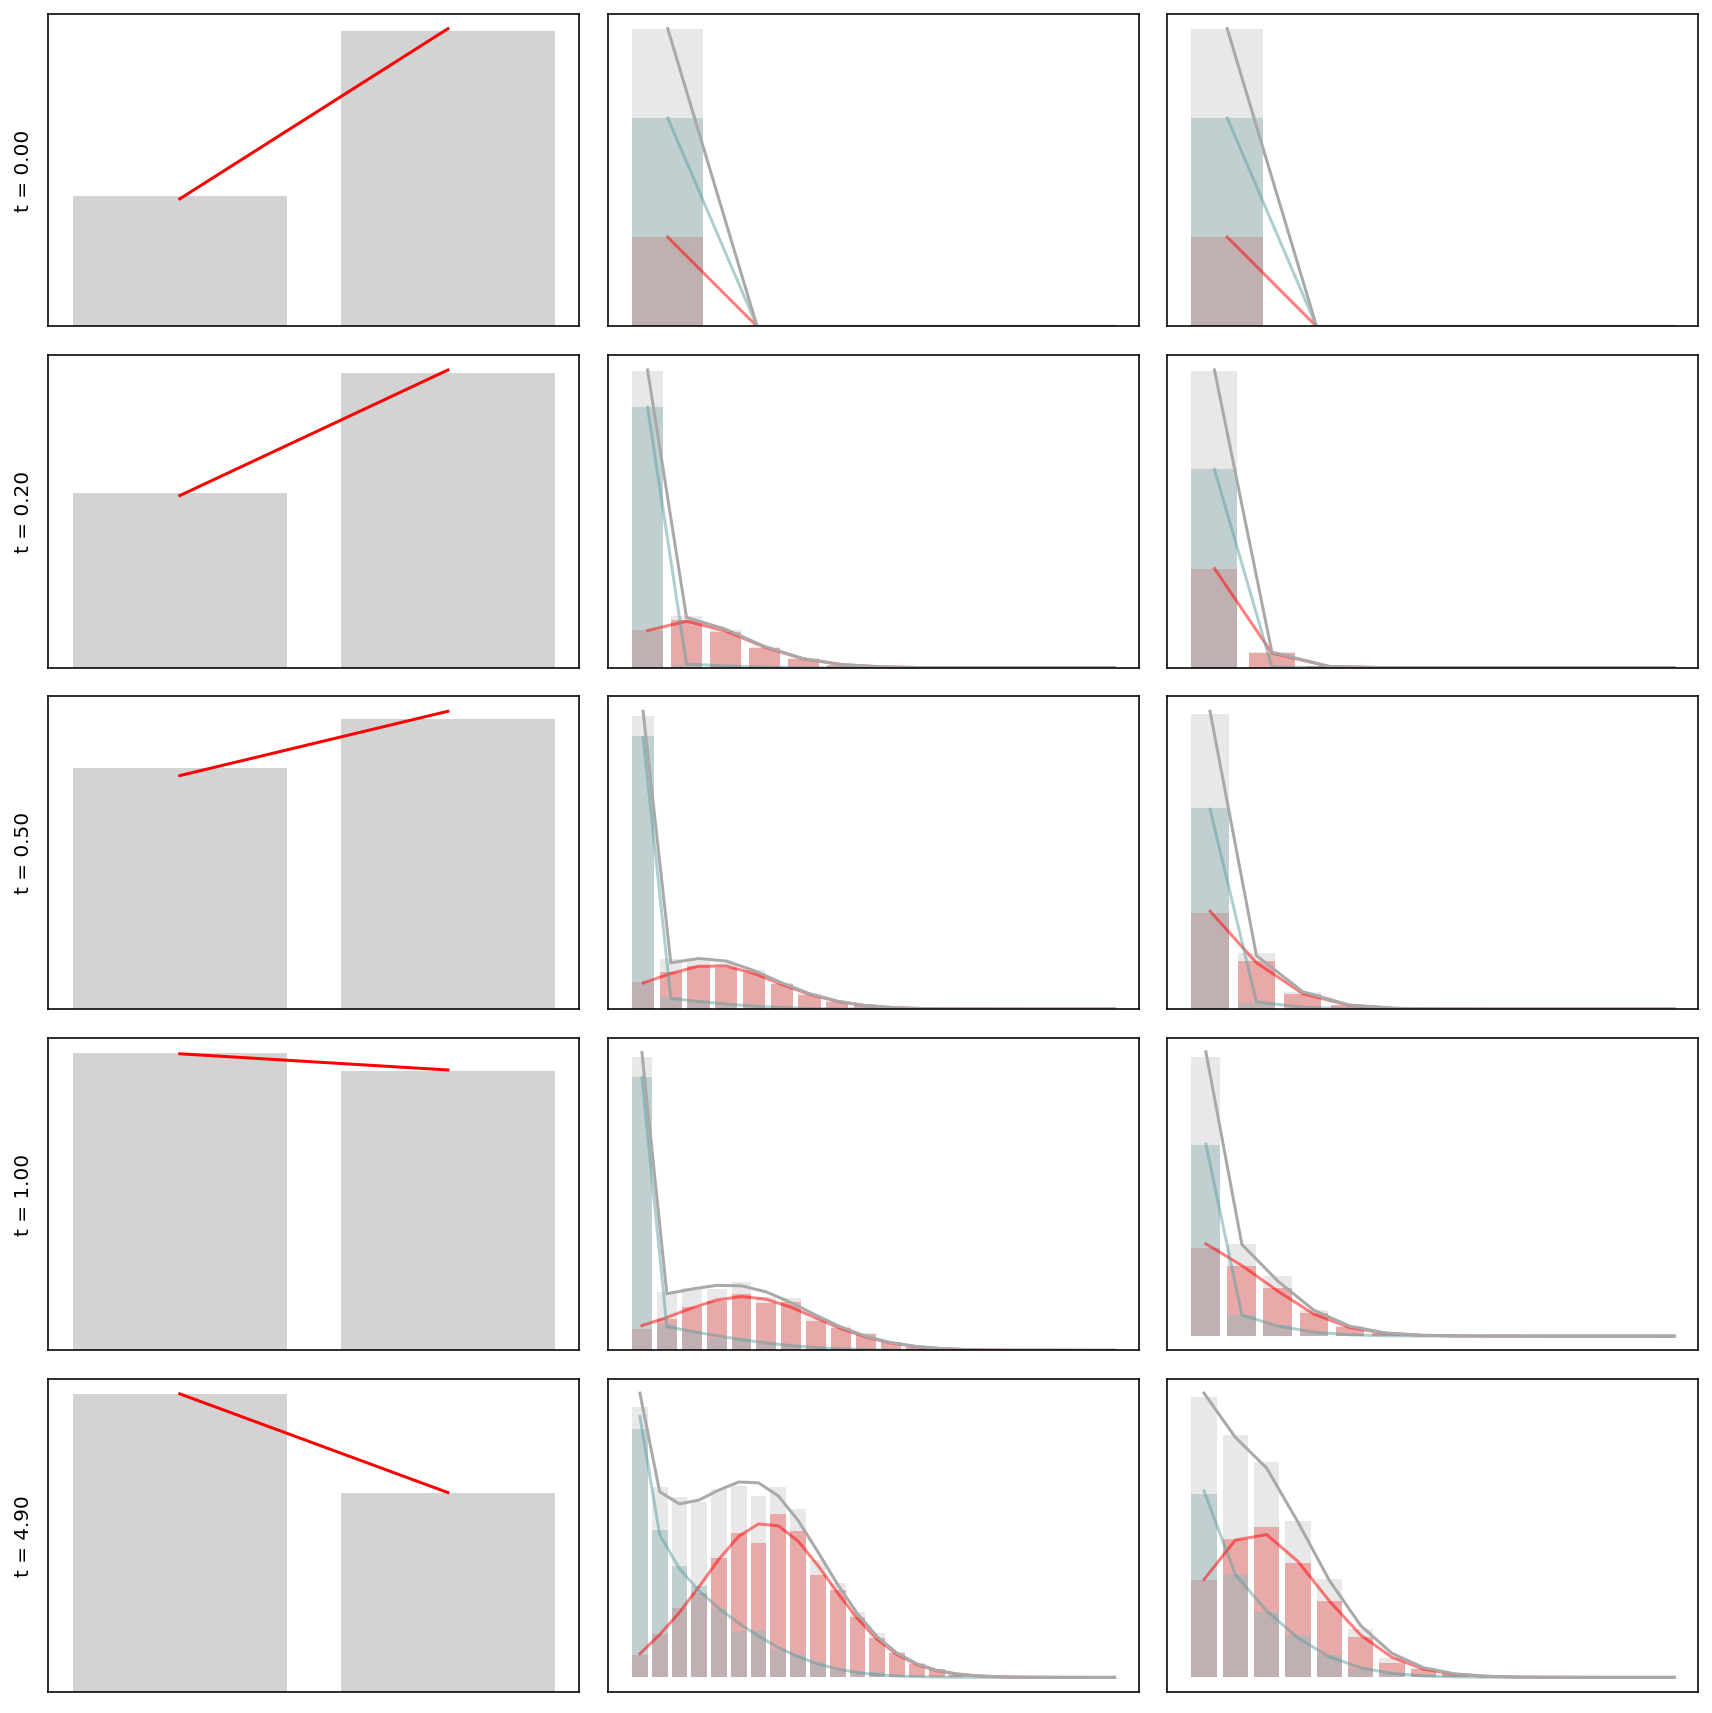

In [19]:
viz_nondelay(t_arr,samples,N,n,H,A,C,initcond,init_state_prob)

## 2-state, 2-species, inhomogeneous, starting at degenerate

In [20]:
initcond = [['categorical',[0.3,0.7]],
            ['deterministic',5],
            ['deterministic',5]]
t_arr,samples,H,A,C,init_state_prob = nondelay_wrapper(N,n,K_val,A_val,beta_val,gamma_val,initcond)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 325.36it/s]


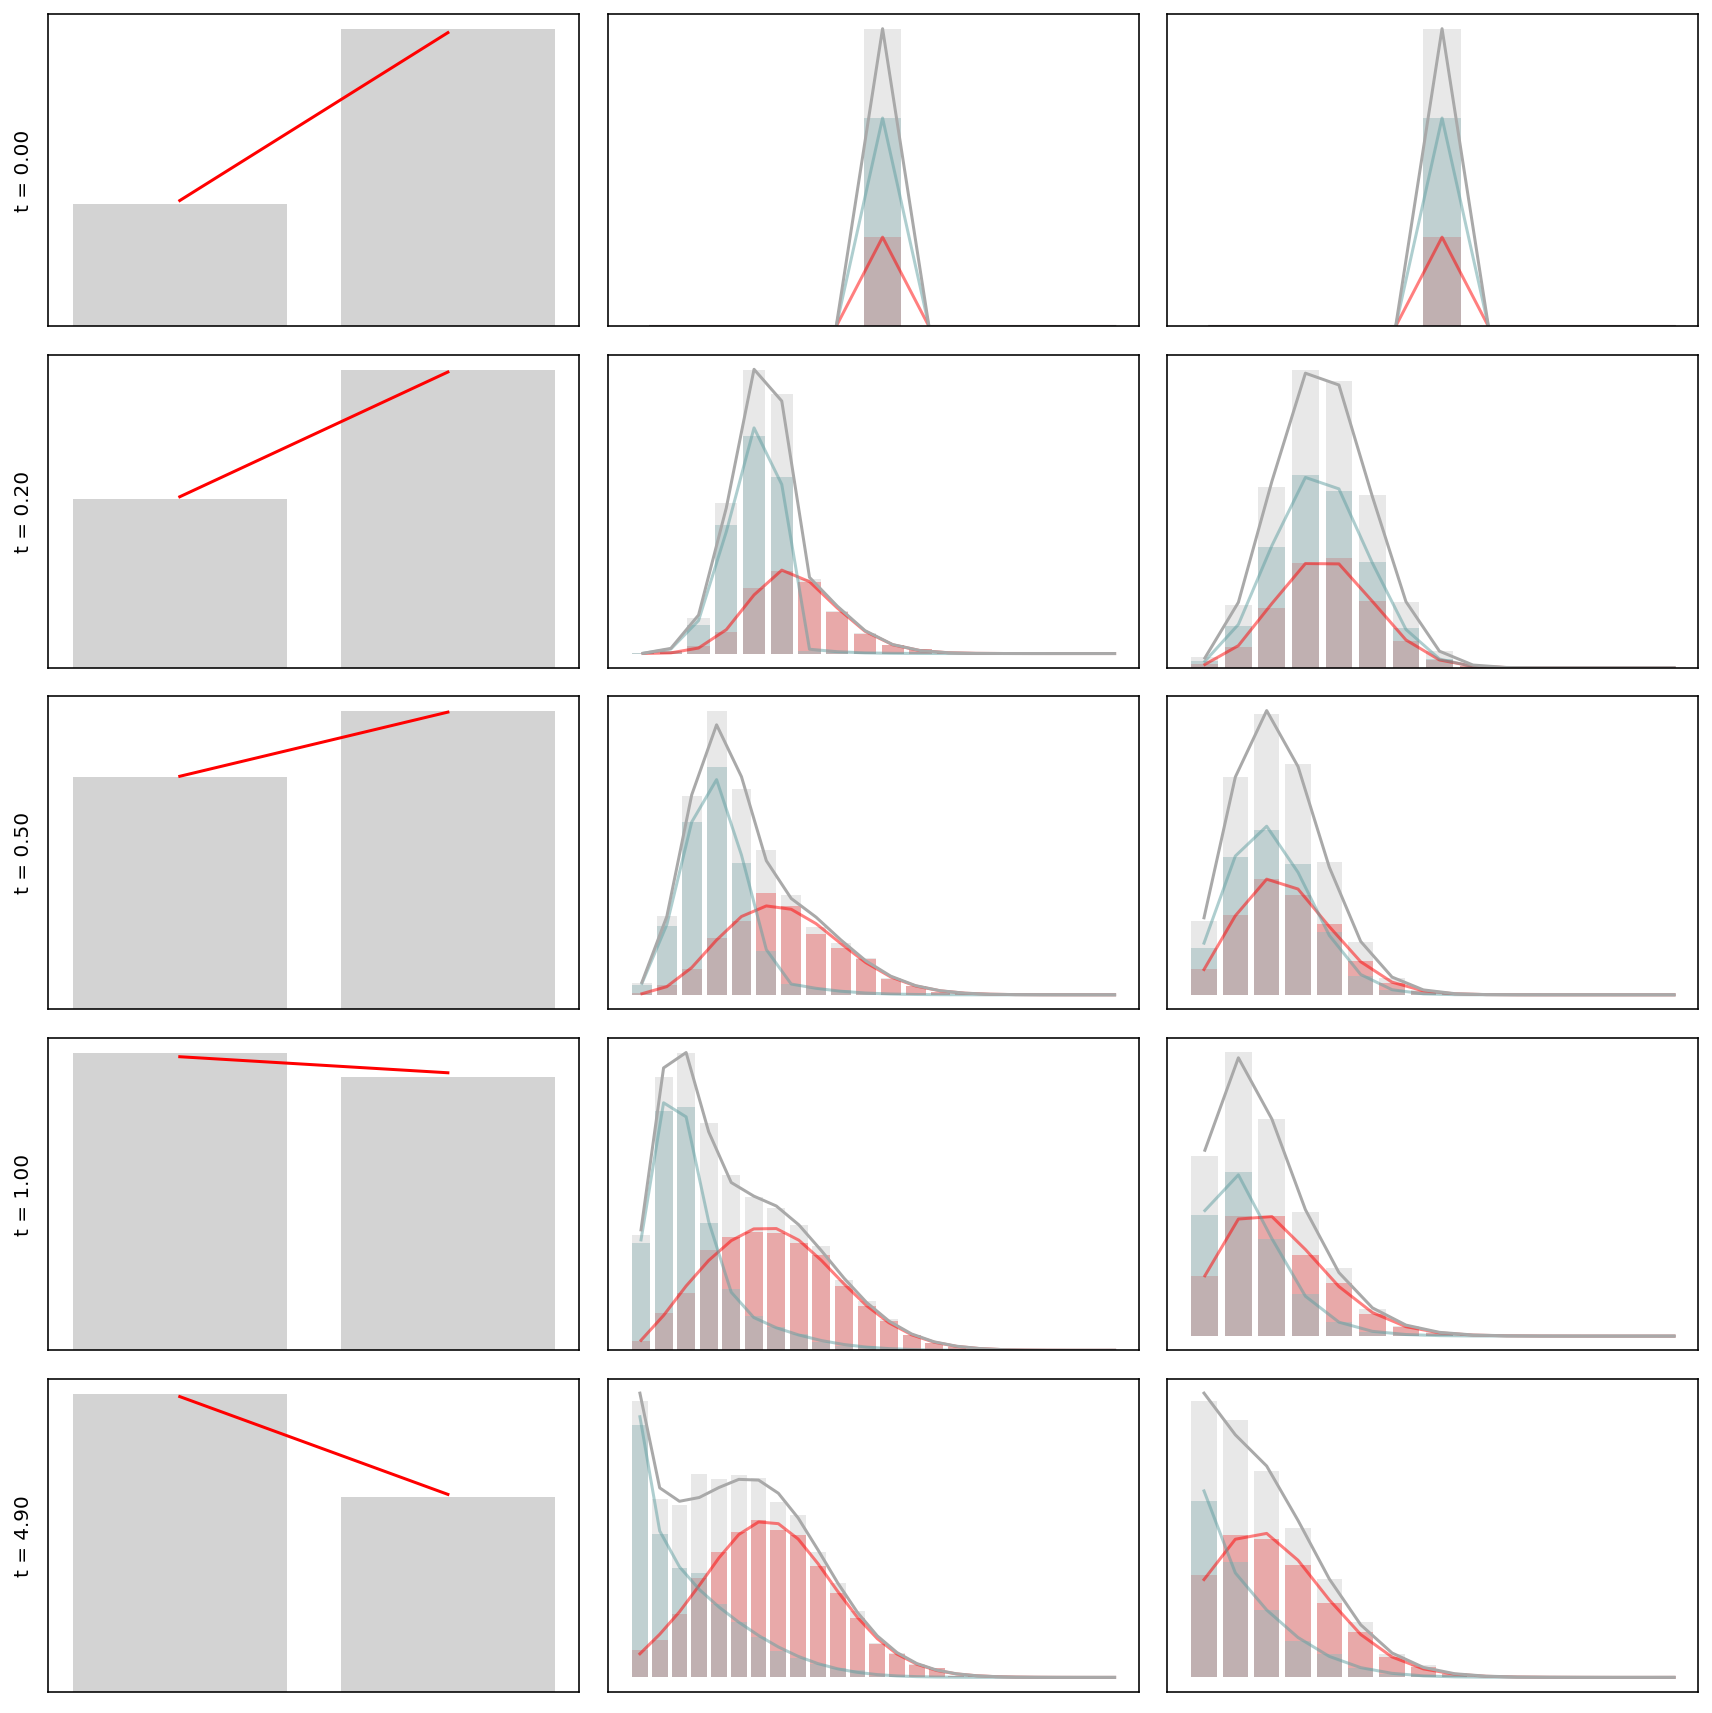

In [21]:
viz_nondelay(t_arr,samples,N,n,H,A,C,initcond,init_state_prob)

## 2-state, 2-species, inhomogeneous, starting at Poisson and degenerate

In [22]:
initcond = [['categorical',[0.3,0.7]],
            ['deterministic',5],
            ['poisson',5]]
t_arr,samples,H,A,C,init_state_prob = nondelay_wrapper(N,n,K_val,A_val,beta_val,gamma_val,initcond)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 324.15it/s]


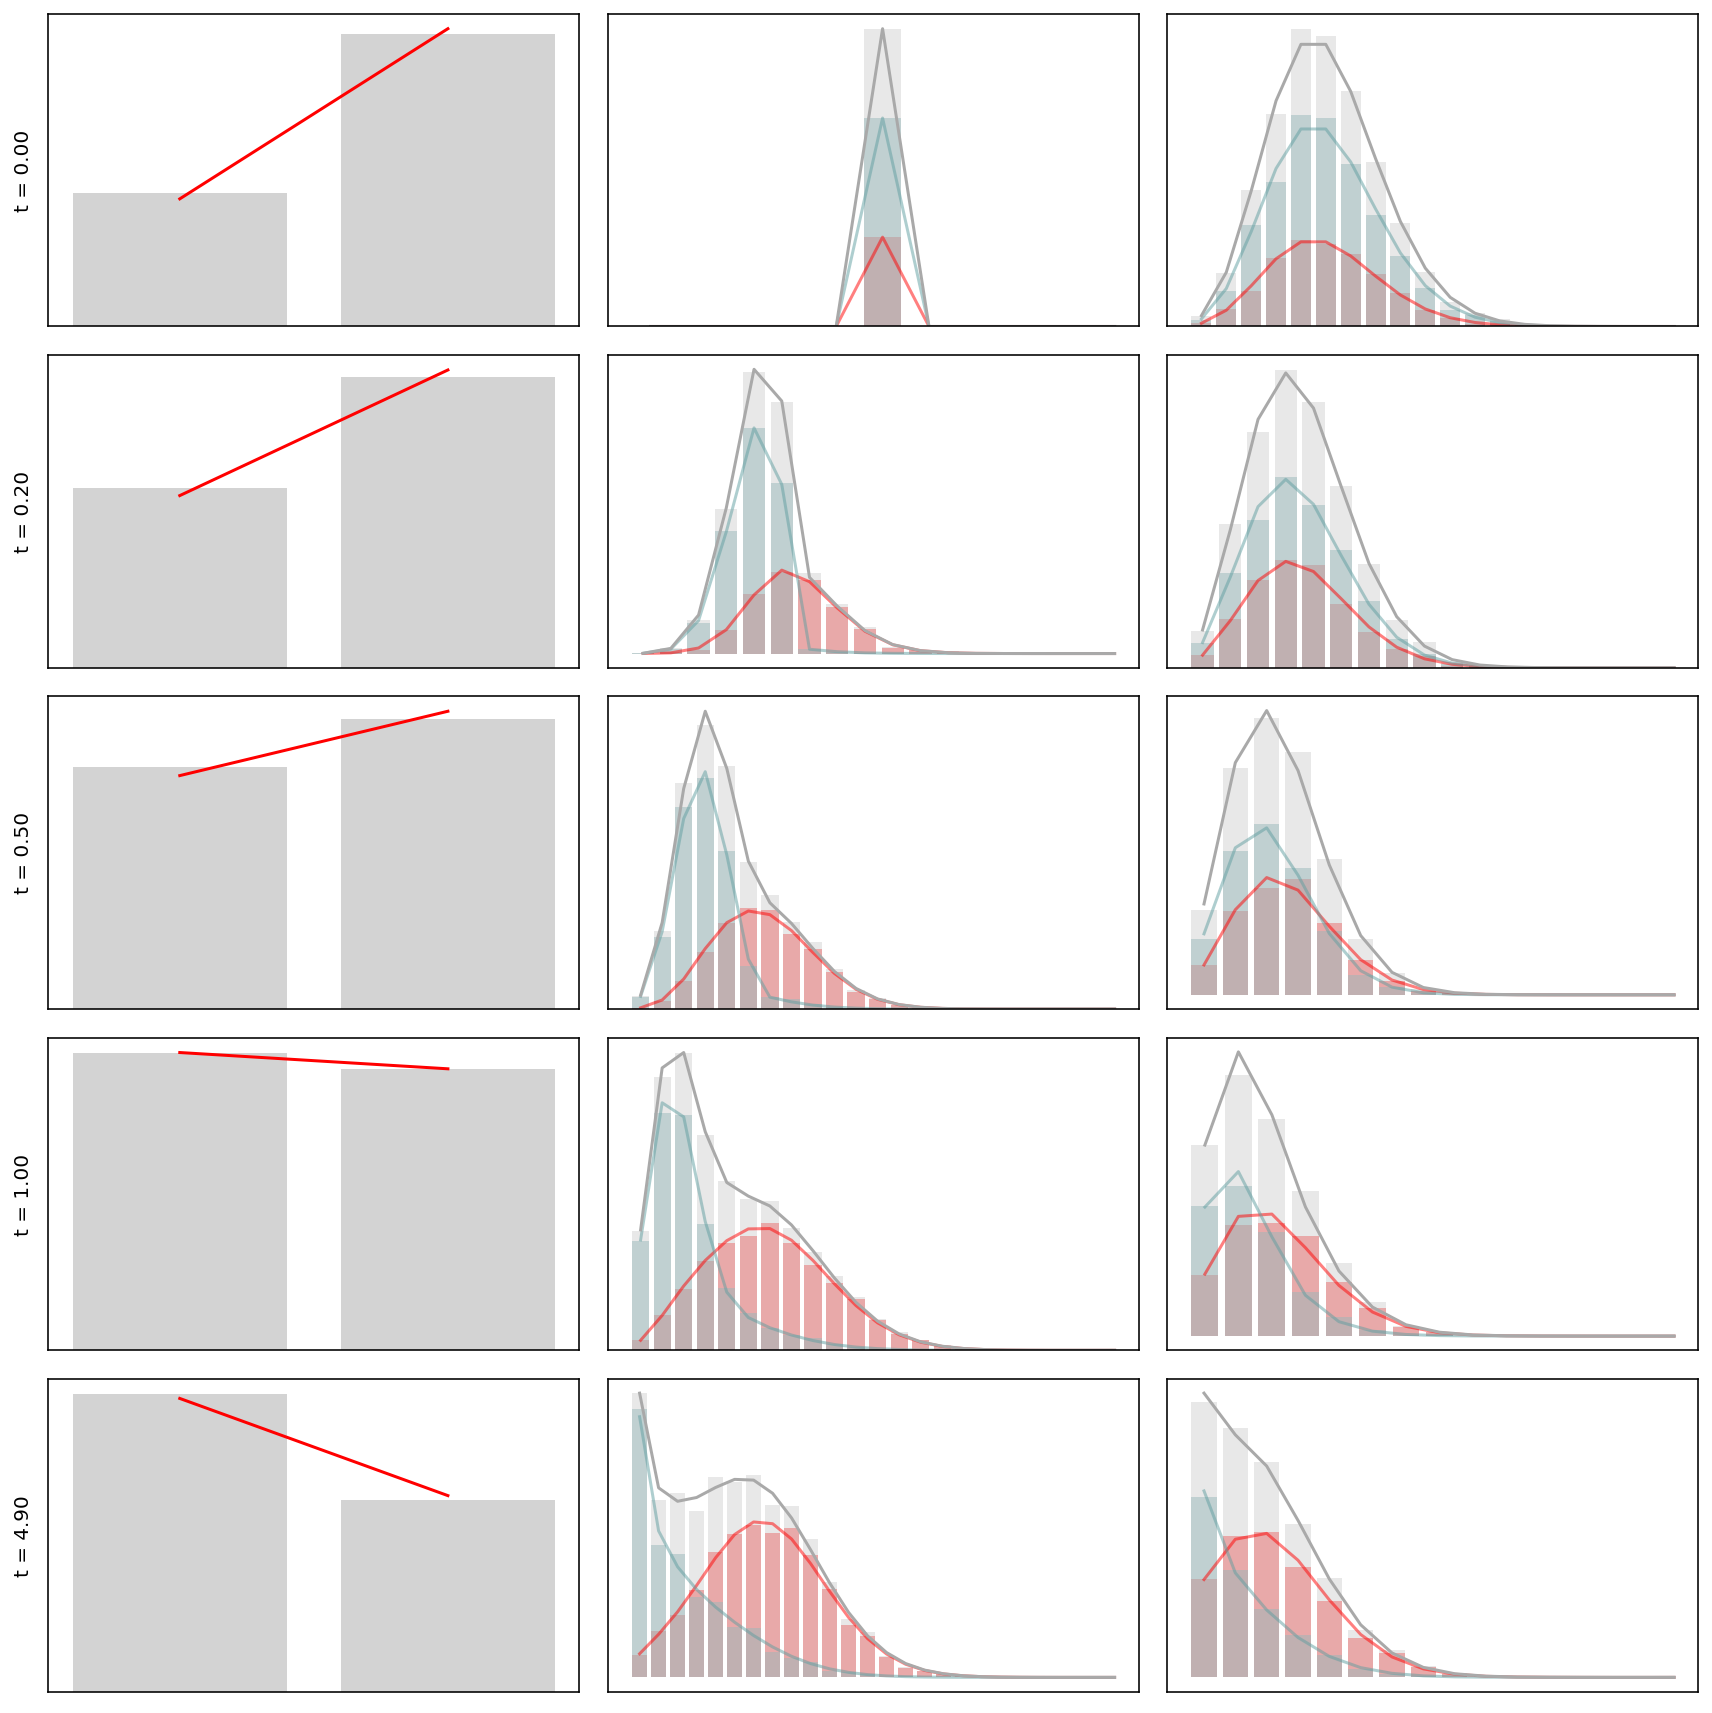

In [23]:
viz_nondelay(t_arr,samples,N,n,H,A,C,initcond,init_state_prob)

## 2-state, 2-species, inhomogeneous, starting at Poisson and degenerate dependent on promoter state

In [24]:
initcond = [['categorical',[0.3,0.7]],
            [['deterministic',0],['poisson',10]],
            [['poisson',5],['deterministic',1]]]
t_arr,samples,H,A,C,init_state_prob = nondelay_wrapper(N,n,K_val,A_val,beta_val,gamma_val,initcond)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 322.55it/s]


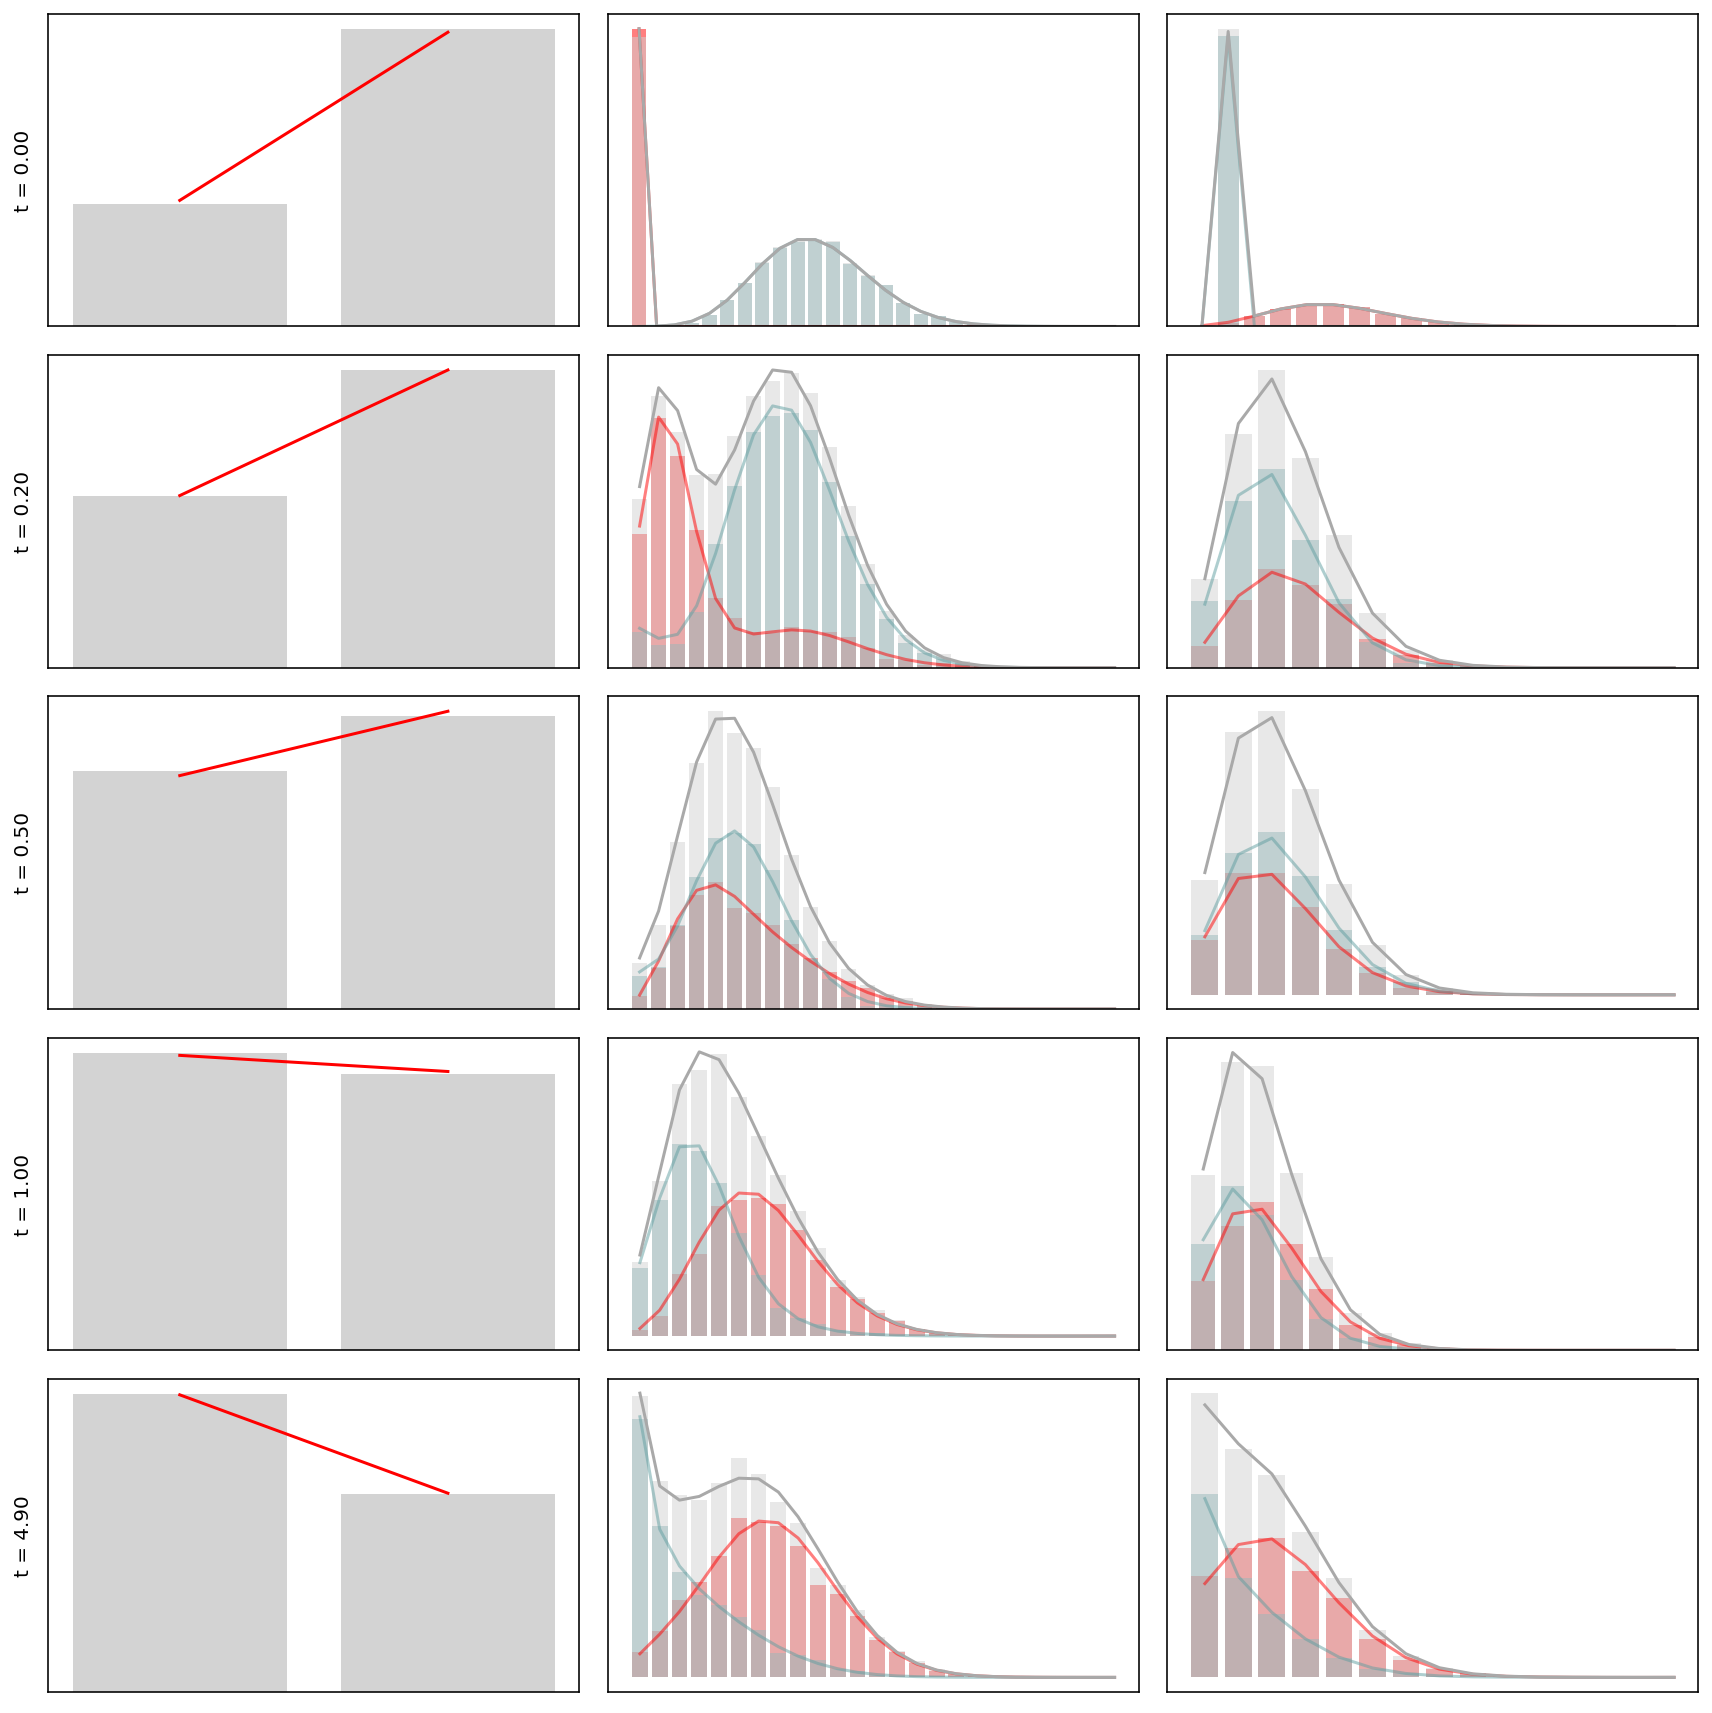

In [25]:
viz_nondelay(t_arr,samples,N,n,H,A,C,initcond,init_state_prob)

## 4-state, 4-species, highly arbitrary initial conditions

Here, we move on to the case of the four-species, four-state system with non-Markovian downstream reactions. In this case, we need to compute the characteristics by hand.

In [26]:

# # Dynamics parameters

k_on = .75
k_off = .5
k_wind = 1
k_unwind = 0.1

N = 4
K_val = [[0,1,k_on],
         [1,0,k_off],
         [0,2,k_wind],
         [2,0,k_unwind],
         [1,3,0.15],
         [3,1,2]]

n = 4
A_val =[[0,1,5.2],[1,2,9.2]]

    
beta_val = [[2,3,1.9],
            [2,4,2.5]]
gamma_val = [[3,0.8]]

H,A,C,S,k,Hss = sim_setup(N,n,K_val,A_val,beta_val,gamma_val)

number_of_cells = 10000
simulation_time = 10

delayed_species = [0,3]
DELAYED_SPECIES_GENERATORS = [list(np.where(S[:,N+j]==1)[0]) for j in delayed_species]
export_arr = np.zeros((len(delayed_species),N+n),dtype=int)
export_arr[0,N+delayed_species[0]] = -1
export_arr[0,N+delayed_species[0]+1] = 1
export_arr[1,N+delayed_species[1]] = -1


tau = [1.1,2.1]
####
update_arr = S

ndel = 50
t_arr = np.linspace(0, simulation_time, ndel,endpoint=False)


samples = np.zeros((number_of_cells, len(t_arr), N+n))
initcond = [['categorical',[0.24,0.1,0.3,0.36]],
            [['deterministic',0],['poisson',10],['deterministic',0],['poisson',2.3]],
            [['deterministic',2],['poisson',3.5],['deterministic',1],['poisson',3]],
            [['deterministic',0],['poisson',2],['deterministic',2],['poisson',5]],
            [['deterministic',21],['poisson',1.1],['deterministic',3],['poisson',0.2]]]
Hss = scipy.linalg.null_space(H.T)
Hss /= Hss.sum()
Hss = Hss.squeeze()

for i in tqdm.tqdm(range(number_of_cells)):
    tau_list = []
    delspec=0
    population_0 = np.zeros(N+n,dtype=int)
    if initcond[0][0]=='thermalized':
        init_state_prob = Hss
    elif initcond[0][0]=='deterministic':
        init_state_prob = np.zeros(N)
        jinit = initcond[0][1]
        init_state_prob[jinit] = 1
    elif initcond[0][0]=='categorical':
        init_state_prob = initcond[0][1]
    if N>1:
        population_0[:N] = np.random.multinomial(1,init_state_prob,1)
    else:
        population_0[:N] = 1
    initial_promoter_state = np.where(population_0[:N]==1)[0][0]
    # print(initial_promoter_state)

    for j,condition in enumerate(initcond[1:]):
        if isinstance(condition[0],str):
            if condition[0]=='deterministic':
                population_0[j+N] = condition[1]
            elif condition[0]=='poisson':
                population_0[j+N] = np.random.poisson(condition[1])
        else:
            if condition[initial_promoter_state][0]=='deterministic':
                population_0[j+N] = condition[initial_promoter_state][1]
            elif condition[initial_promoter_state][0]=='poisson':
                population_0[j+N] = np.random.poisson(condition[initial_promoter_state][1])
        if j in delayed_species:
            tau_list.append([tau[delspec]]*population_0[j+N])
            delspec+=1
    samples[i, :, :],event_t,event_x,_ = markovian_simulate(
           propfun_generic, update_arr, population_0, t_arr, \
           tau, DELAYED_SPECIES_GENERATORS, export_arr,tau_list,\
           True,(k,K_val,A_val,beta_val,gamma_val,N))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:32<00:00, 65.40it/s]


In [27]:
H

array([[-1.75,  0.75,  1.  ,  0.  ],
       [ 0.5 , -0.65,  0.  ,  0.15],
       [ 0.1 ,  0.  , -0.1 ,  0.  ],
       [ 0.  ,  2.  ,  0.  , -2.  ]])

In [28]:
A

array([[5.2, 0. , 0. , 0. ],
       [0. , 9.2, 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ]])

In [29]:
C

array([[ 0. ,  0. ,  0. ,  0. ],
       [ 0. , -4.4,  1.9,  2.5],
       [ 0. ,  0. , -0.8,  0. ],
       [ 0. ,  0. ,  0. ,  0. ]])

In [30]:
S

array([[-1,  1,  0,  0,  0,  0,  0,  0],
       [ 1, -1,  0,  0,  0,  0,  0,  0],
       [-1,  0,  1,  0,  0,  0,  0,  0],
       [ 1,  0, -1,  0,  0,  0,  0,  0],
       [ 0, -1,  0,  1,  0,  0,  0,  0],
       [ 0,  1,  0, -1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0, -1,  1,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  1],
       [ 0,  0,  0,  0,  0,  0, -1,  0]])

In [31]:
DELAYED_SPECIES_GENERATORS

[[6], [9]]

In [32]:
export_arr

array([[ 0,  0,  0,  0, -1,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1]])

In [33]:
c34 = C[1,2]
c35 = C[1,3]
c40 = -C[2,2]

In [34]:
kvec = [c34,c35,c40]

### Solution

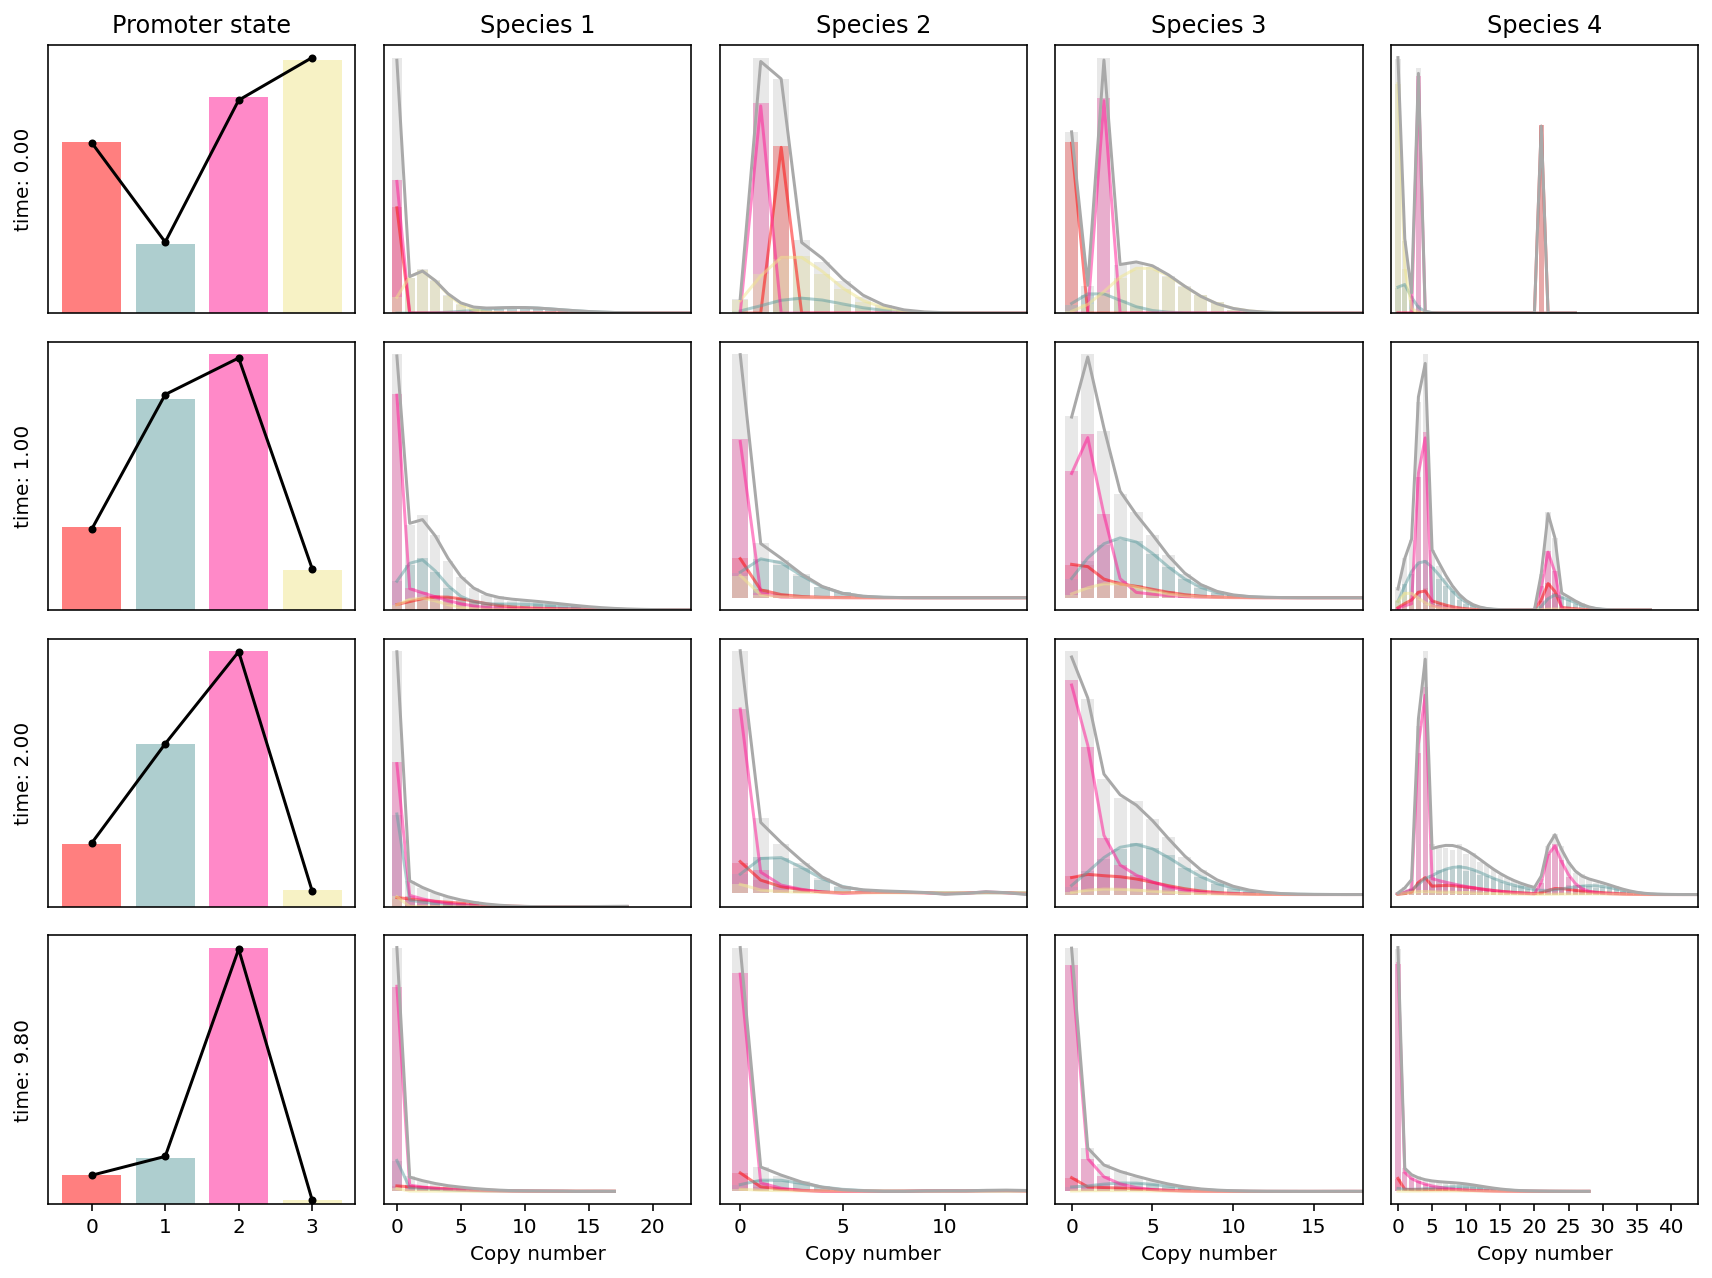

In [52]:
nt = 4
fig1,ax1=plt.subplots(nt,n+1,figsize=(12,9))
max_ = np.zeros(n)
for k,tind in enumerate([0,5,10,49]):
    t=t_arr[tind]

    X=samples[:,tind,:]
    ax1[k,0].bar(np.arange(N),X[:,:N].mean(0),color=conditional_colors,alpha=alf)

    Pss_gene = np.dot(scipy.linalg.expm(t*H.T),init_state_prob)
    ax1[k,0].plot(Pss_gene,'k.-')

    ax1[k,0].set_xticks([])
    ax1[k,0].set_yticks([])
    for i in range(n):
        mx = [1]*n
        mx[i] = int(X[:,N+i].max()+6)
        Pss = pss_wrapper_special(H,A,kvec,tau,t,mx,N,initcond)
        for j in range(N):
            cf = X[:,j]==1
            bins = np.arange(X[cf,N+i].max()+6)-0.5
            hist,_ = np.histogram(X[cf,N+i],bins,density=True)
            ax1[k,i+1].bar(bins[:-1]+0.5,hist*cf.mean(),color=conditional_colors[j],alpha=alf)

            ax1[k,i+1].plot(Pss[:,j],color=conditional_colors[j],alpha=alf)

        if X[:,N+i].max()+2>max_[i]:
            max_[i] = X[:,N+i].max()+2
        bins = np.arange(X[:,N+i].max()+6)-0.5
        hist,_ = np.histogram(X[:,N+i],bins,density=True)
        ax1[k,i+1].bar(bins[:-1]+0.5,hist,color=uncond_colors[0],alpha=alf)

        mx = [1]*n
        mx[i] = int(X[:,N+i].max()+6)
        Pss = pss_wrapper_special(H,A,kvec,tau,t,mx,N,initcond)
        ax1[k,i+1].plot(Pss.sum(1),color=uncond_colors[1])


        ax1[k,i+1].set_xticks([])
        ax1[k,i+1].set_yticks([])
    ax1[k,0].set_ylabel('time: {:.2f}'.format(t))
ax1[0,0].set_title('Promoter state')
for j in range(1,n+1):
    ax1[0,j].set_title('Species '+str(j))
ax1[nt-1,0].set_xticks(np.arange(4))
for j in range(n):
    for k in range(nt):
        ax1[k,j+1].set_xlim([-1,max_[j]])
    ax1[nt-1,j+1].set_xticks(np.arange(0,max_[j],5))
    ax1[nt-1,j+1].set_xlabel('Copy number')
fig1.tight_layout()
plt.savefig('fig/supp_complex_sim.png',dpi=450,bbox_inches="tight")

In [36]:
print('Runtime: {:.1f} minutes.'.format((time.time()-t1)/60))

Runtime: 6.4 minutes.


In [51]:
(5+X.max(0)).prod()*4

656377344.0

In [48]:
X.max(0)

array([ 1.,  1.,  1.,  1., 12.,  9., 14., 23.])

In [50]:
(14+5)*(23+5)

532